In [1]:
import tensorflow as tf
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

Load MNIST data

In [2]:
#
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('datasets/mnist')

Extracting datasets/mnist\train-images-idx3-ubyte.gz
Extracting datasets/mnist\train-labels-idx1-ubyte.gz
Extracting datasets/mnist\t10k-images-idx3-ubyte.gz
Extracting datasets/mnist\t10k-labels-idx1-ubyte.gz


Some settings

In [3]:
#
n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20 # codings 
n_hidden4 = n_hidden2 
n_hidden5 = n_hidden1 
n_outputs = n_inputs 
learning_rate = 0.001

Construct the architecture of the variational autoencoder

In [4]:
tf.reset_default_graph()

In [5]:
initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu,
                        kernel_initializer=initializer)

In [6]:
X = tf.placeholder(dtype=tf.float32, shape=[None, n_inputs])

In [7]:
with tf.name_scope('NN'):
    hidden1 = my_dense_layer(X, n_hidden1)
    hidden2 = my_dense_layer(hidden1, n_hidden2)
    hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
    hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
    noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
    # hidden3 = N(hidden3_mean, sigma**2), where sigma = exp(gamma/2)
    hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
    hidden4 = my_dense_layer(hidden3, n_hidden4)
    hidden5 = my_dense_layer(hidden4, n_hidden5)
    logits = my_dense_layer(hidden5, n_outputs, activation=None)
    outputs = tf.nn.sigmoid(logits)

Define the loss function

The reconstruction loss is squared error or entropy. Don't average over input dimension.

For the $i$-th data point, the latent loss is
$L_i = 0.5 \times \sum_{j=1}^D (\mu_j^2 + \sigma_j^2 - \log(\sigma_j^2) -1) $ where D is the dimension of the coding layer, and D=20 in this example. Based on $\sigma^2 = \exp{(\gamma)}$, we have

$L_i = 0.5 \times \sum_{j=1}^D (\mu_j^2 + \exp(\gamma_j) - \gamma_j -1) $

Then the total latent error is $L=\sum_{i=1}^m L_i$ where m is the number of data points. {Don't average over coding dimension.}

In [8]:
logits.shape

TensorShape([Dimension(None), Dimension(784)])

In [9]:
X.shape

TensorShape([Dimension(None), Dimension(784)])

In [10]:
with tf.name_scope('loss'):
    # the reconstruction error
    mse = tf.reduce_sum(tf.square(X-outputs))
    reconstruction_loss = tf.reduce_sum(mse) # sum, not mean

    # the latent loss (K-L divergence)
    latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) 
                                      + tf.square(hidden3_mean)
                                      - 1 - hidden3_gamma)

    # the total loss
    loss = reconstruction_loss + latent_loss

Define optimizer

In [11]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss)

Training

In [12]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epoch = 50
batch_size = 150
n_batch = mnist.train.num_examples // batch_size
n_digits = 60

In [13]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epoch):
        for batch in range(n_batch):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_op, feed_dict={X: X_batch})
        loss_val = sess.run(loss, feed_dict={X: mnist.train.images})
        print('Epoch: {}, validation error: {:.4f}'.format(epoch+1, loss_val))
    
    saver.save(sess, 'tmp/VAE_mse.ckpt')

Epoch: 1, validation error: 1970436.0000
Epoch: 2, validation error: 1847070.2500
Epoch: 3, validation error: 1795961.2500
Epoch: 4, validation error: 1762748.2500
Epoch: 5, validation error: 1731203.8750
Epoch: 6, validation error: 1721958.7500
Epoch: 7, validation error: 1700653.2500
Epoch: 8, validation error: 1704675.0000
Epoch: 9, validation error: 1669895.3750
Epoch: 10, validation error: 1664091.7500
Epoch: 11, validation error: 1659880.3750
Epoch: 12, validation error: 1638882.1250
Epoch: 13, validation error: 1629675.2500
Epoch: 14, validation error: 1637407.1250
Epoch: 15, validation error: 1623804.2500
Epoch: 16, validation error: 1620062.7500
Epoch: 17, validation error: 1604370.3750
Epoch: 18, validation error: 1608911.5000
Epoch: 19, validation error: 1605160.6250
Epoch: 20, validation error: 1593472.2500
Epoch: 21, validation error: 1588415.7500
Epoch: 22, validation error: 1585618.8750
Epoch: 23, validation error: 1593699.5000
Epoch: 24, validation error: 1584259.0000
E

In [14]:
with tf.Session() as sess:
    saver.restore(sess, 'tmp/VAE_mse.ckpt')
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    output_val = sess.run(outputs, feed_dict={hidden3: codings_rnd})

INFO:tensorflow:Restoring parameters from tmp/VAE_mse.ckpt


Visualize generated digits

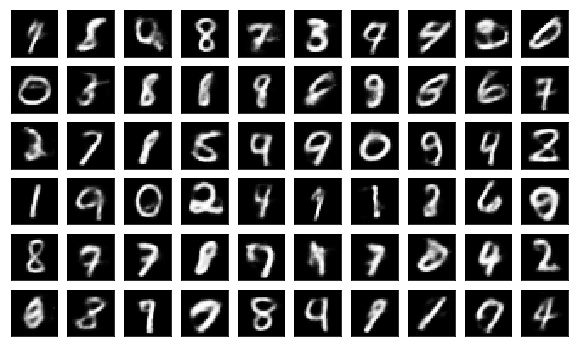

In [15]:
fig, axes = plt.subplots(6, 10, figsize=(10, 6))
axes_flat = axes.ravel()
for i in range(n_digits):
    axes_flat[i].imshow(output_val[i].reshape((28, -1)), cmap='gray')
    axes_flat[i].get_xaxis().set_visible(False)
    axes_flat[i].get_yaxis().set_visible(False)